# Set up

In [275]:
import pandas as pd
import patsy
import numpy as np
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import PredefinedSplit, GridSearchCV, cross_val_score
from sklearn.decomposition import PCA
from skopt.space import Real, Integer
from skopt.utils import use_named_args
from skopt import gp_minimize
from sklearn.feature_selection import RFECV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import random
import math

# Getting data

In [92]:
file_name = '../csvs/element_gameweek_features_v06.csv'

In [93]:
element_gameweek_df = pd.read_csv(file_name)

In [94]:
current_event = 20

In [95]:
last_train_event = 15

In [96]:
element_gameweek_df =\
element_gameweek_df[
    (element_gameweek_df['event'] <= current_event)
]

In [97]:
element_gameweek_df.fillna(
    element_gameweek_df[element_gameweek_df['event'] <= last_train_event].mean(),
    inplace=True
)

In [98]:
element_gameweek_df = element_gameweek_df[element_gameweek_df['rolling_avg_minutes_element_p3'] >= 60]

# Modelling data

## Splitting data

In [99]:
test_fold = [-1 if i <= last_train_event else 0 for i in element_gameweek_df['event']]
ps = PredefinedSplit(test_fold)

In [100]:
for train_index, test_index in ps.split():
    element_gameweek_df_train, element_gameweek_df_test = \
    element_gameweek_df.copy().iloc[train_index], element_gameweek_df.copy().iloc[test_index]

## Scaling data

In [11]:
scaled_feature_cols = [
    i for i in element_gameweek_df.columns if i not in [
        'safe_web_name', 'element', 'event', 'fixture', 'team',
        'opposition_team', 'element_type', 'was_home', 'is_sunday',
        'is_weekday', 'is_late', 'is_early', 'has_high_points_ever_element',
        'total_points', 'minutes', 'rolling_value_points'
    ]
]

scaled_feature_cols

['value',
 'rolling_avg_total_points_element',
 'rolling_max_total_points_element',
 'rolling_avg_bps_element',
 'rolling_avg_bonus_element',
 'rolling_avg_goals_scored_element',
 'rolling_avg_minutes_element',
 'rolling_avg_clean_sheets_element',
 'rolling_avg_completed_passes_element',
 'rolling_avg_recoveries_element',
 'rolling_avg_assists_element',
 'rolling_avg_key_passes_element',
 'rolling_avg_winning_goals_element',
 'rolling_avg_tackled_element',
 'rolling_avg_dribbles_element',
 'rolling_avg_clearances_blocks_interceptions_element',
 'rolling_avg_big_chances_created_element',
 'rolling_avg_target_missed_element',
 'rolling_avg_fouls_element',
 'rolling_avg_tackles_element',
 'rolling_avg_open_play_crosses_element',
 'rolling_avg_offside_element',
 'rolling_avg_big_chances_missed_element',
 'rolling_avg_saves_element',
 'rolling_avg_goals_conceded_element',
 'rolling_avg_attempted_passes_element',
 'rolling_avg_errors_leading_to_goal_element',
 'rolling_avg_errors_leading_to_

In [12]:
scaled_df_train = element_gameweek_df_train.copy()
scaled_df_test = element_gameweek_df_test.copy()
scaled_df = element_gameweek_df.copy()

scaler = StandardScaler().fit(scaled_df_train[scaled_feature_cols].values)

scaled_df_train = scaler.transform(scaled_df_train[scaled_feature_cols].values)
scaled_df_test = scaler.transform(scaled_df_test[scaled_feature_cols].values)
scaled_df = scaler.transform(scaled_df[scaled_feature_cols].values)

element_gameweek_df_train[scaled_feature_cols] = scaled_df_train
element_gameweek_df_test[scaled_feature_cols] = scaled_df_test
element_gameweek_df[scaled_feature_cols] = scaled_df

## Building model

In [146]:
formula = \
'total_points ~ C(element_type) + C(team) + C(opposition_team) + ' + \
' + '.join([i for i in element_gameweek_df.columns if i not in
 [
     'safe_web_name',
     'element',
     'event',
     'fixture',
     'team',
     'opposition_team',
     'element_type',
     'minutes',
     'rolling_value_points',
     'total_points',
     
     'expected_total_points_against_opposition_team',
     'rolling_avg_total_points_element_home',
     'rolling_max_total_points_element',
     'rolling_avg_bps_element',
     'expected_total_points_element_home_away',
     'rolling_avg_total_points_element_away',
     'rolling_avg_total_points_own_team',
     'rolling_avg_total_points_against_opposition_team',
     'rolling_avg_minutes_element',
     'rolling_avg_total_points_opposition_team',
     'rolling_avg_dribbles_element',
     'rolling_avg_total_points_against_opposition_team_element_type',
     'rolling_avg_total_points_against_opposition_team_element_type_away',
     'rolling_avg_total_points_against_opposition_team_element_type_home',
     'rolling_avg_goals_conceded_element',
     'rolling_avg_completed_passes_element',
     'rolling_avg_total_points_element_type',
     'rolling_avg_recoveries_element',
 ]])

In [147]:
print(formula)

total_points ~ C(element_type) + C(team) + C(opposition_team) + was_home + is_sunday + is_weekday + is_early + is_late + value + rolling_avg_total_points_element + has_high_points_ever_element + rolling_avg_bonus_element + rolling_avg_goals_scored_element + rolling_avg_clean_sheets_element + rolling_avg_assists_element + rolling_avg_key_passes_element + rolling_avg_winning_goals_element + rolling_avg_tackled_element + rolling_avg_clearances_blocks_interceptions_element + rolling_avg_big_chances_created_element + rolling_avg_target_missed_element + rolling_avg_fouls_element + rolling_avg_tackles_element + rolling_avg_open_play_crosses_element + rolling_avg_offside_element + rolling_avg_big_chances_missed_element + rolling_avg_saves_element + rolling_avg_attempted_passes_element + rolling_avg_errors_leading_to_goal_element + rolling_avg_errors_leading_to_goal_attempt_element + rolling_avg_own_goals_element + rolling_avg_penalties_concededd_element + rolling_avg_penalties_missed_element +

In [148]:
y, X = patsy.dmatrices(formula, element_gameweek_df, return_type='matrix')

In [149]:
for train_index, test_index in ps.split():
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

## Selecting features

In [155]:
estimator = DecisionTreeRegressor(min_samples_leaf=0.0193)
selector = RFECV(estimator, step=1,
                 scoring='neg_mean_squared_error',
                 cv=ps, n_jobs=1, verbose=1)
selector.fit(
    X,
    y.ravel()
)

Fitting estimator with 80 features.
Fitting estimator with 79 features.
Fitting estimator with 78 features.
Fitting estimator with 77 features.
Fitting estimator with 76 features.
Fitting estimator with 75 features.
Fitting estimator with 74 features.
Fitting estimator with 73 features.
Fitting estimator with 72 features.
Fitting estimator with 71 features.
Fitting estimator with 70 features.
Fitting estimator with 69 features.
Fitting estimator with 68 features.
Fitting estimator with 67 features.
Fitting estimator with 66 features.
Fitting estimator with 65 features.
Fitting estimator with 64 features.
Fitting estimator with 63 features.
Fitting estimator with 62 features.
Fitting estimator with 61 features.
Fitting estimator with 60 features.
Fitting estimator with 59 features.
Fitting estimator with 58 features.
Fitting estimator with 57 features.
Fitting estimator with 56 features.
Fitting estimator with 55 features.
Fitting estimator with 54 features.
Fitting estimator with 53 fe

RFECV(cv=PredefinedSplit(test_fold=array([-1, -1, ...,  0,  0])),
      estimator=DecisionTreeRegressor(criterion='mse', max_depth=None,
                                      max_features=None, max_leaf_nodes=None,
                                      min_impurity_decrease=0.0,
                                      min_impurity_split=None,
                                      min_samples_leaf=0.0193,
                                      min_samples_split=2,
                                      min_weight_fraction_leaf=0.0,
                                      presort=False, random_state=None,
                                      splitter='best'),
      min_features_to_select=1, n_jobs=1, scoring='neg_mean_squared_error',
      step=1, verbose=1)

In [156]:
sum(selector.support_)

16

In [157]:
list(pd.Series(X.design_info.column_names)[selector.support_])

['is_late',
 'value',
 'rolling_avg_total_points_element',
 'rolling_avg_bonus_element',
 'rolling_avg_goals_scored_element',
 'rolling_avg_clean_sheets_element',
 'rolling_avg_tackled_element',
 'rolling_avg_clearances_blocks_interceptions_element',
 'rolling_avg_big_chances_created_element',
 'rolling_avg_fouls_element',
 'rolling_avg_tackles_element',
 'rolling_avg_offside_element',
 'rolling_avg_saves_element',
 'rolling_avg_attempted_passes_element',
 'rolling_avg_minutes_element_p3',
 'rolling_avg_goals_scored_opposition_team']

In [158]:
X_sel = X[:,selector.support_]
X_train_sel = X_train[:,selector.support_]
X_test_sel = X_test[:,selector.support_]

## Tuning model

### GP tuner

In [150]:
space  = [
    Real(0.01, 0.5, 'uniform', name='min_samples_leaf'),
]

In [159]:
gp_model = DecisionTreeRegressor()

@use_named_args(space)
def objective(**params):
    gp_model.set_params(**params)

    return -np.mean(
        cross_val_score(
            gp_model,
            X,
#             X_sel,
            y.ravel(),
            cv=ps,
            n_jobs=1,
            scoring="neg_mean_squared_error"))

In [160]:
res_gp_arr = []
for i in range(1, 2):
    print('minimisation iteration', i)
    res_gp = gp_minimize(objective, space, n_calls=50, verbose=2)
    res_gp_arr.append(res_gp)

minimisation iteration 1
Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 0.0217
Function value obtained: 9.6156
Current minimum: 9.6156
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 0.0249
Function value obtained: 9.4427
Current minimum: 9.4427
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 0.0243
Function value obtained: 9.4701
Current minimum: 9.4427
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 0.0204
Function value obtained: 9.5417
Current minimum: 9.4427
Iteration No: 5 started. Evaluating function at random point.
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 0.0176
Function value obtained: 9.5678
Current minimum: 9.4427
Iteration 

Iteration No: 41 ended. Search finished for the next optimal point.
Time taken: 0.9177
Function value obtained: 9.5703
Current minimum: 9.2720
Iteration No: 42 started. Searching for the next optimal point.
Iteration No: 42 ended. Search finished for the next optimal point.
Time taken: 0.8471
Function value obtained: 9.4459
Current minimum: 9.2720
Iteration No: 43 started. Searching for the next optimal point.
Iteration No: 43 ended. Search finished for the next optimal point.
Time taken: 0.9213
Function value obtained: 9.5681
Current minimum: 9.2720
Iteration No: 44 started. Searching for the next optimal point.
Iteration No: 44 ended. Search finished for the next optimal point.
Time taken: 0.9242
Function value obtained: 9.5066
Current minimum: 9.2720
Iteration No: 45 started. Searching for the next optimal point.
Iteration No: 45 ended. Search finished for the next optimal point.
Time taken: 0.8737
Function value obtained: 9.2720
Current minimum: 9.2720
Iteration No: 46 started. Sea

In [154]:
# Full features (no elements)
for i in res_gp_arr:
    print(i.fun)
print('\n')
for i in res_gp_arr:
    print(i.x)

9.245966133299419


[0.01925081691553842]


In [161]:
# Selected features (no elements)
for i in res_gp_arr:
    print(i.fun)
print('\n')
for i in res_gp_arr:
    print(i.x)

9.271984774259298


[0.031043433817362916]


### Grid search

#### Leaf size

In [345]:
gs_parameters_ls = {
    'min_samples_leaf': [2**i for i in np.linspace(-8, -1, 40)]
}

In [346]:
gs_model = GridSearchCV(
    DecisionTreeRegressor(),
    gs_parameters_ls,
    scoring=['neg_mean_absolute_error', 'neg_mean_squared_error'],
    refit=False,
    cv=ps,
    error_score=100, n_jobs=1)
gs_model.fit(X, y.ravel())

gs_model_df = pd.DataFrame(gs_model.cv_results_)[[
    'param_min_samples_leaf',
    'split0_test_neg_mean_absolute_error',
    'split0_test_neg_mean_squared_error'
]]

In [347]:
gs_model_df['param_min_samples_leaf_log'] = gs_model_df['param_min_samples_leaf'].apply(lambda x: math.log(x, 2))
gs_model_df

,param_min_samples_leaf,split0_test_neg_mean_absolute_error,split0_test_neg_mean_squared_error,param_min_samples_leaf_log
0,0.00390625,-2.404151,-11.500902,-8.000000
1,0.00442375,-2.498668,-11.876809,-7.820513
2,0.00500982,-2.492739,-11.779475,-7.641026
3,0.00567353,-2.488554,-11.646924,-7.461538
4,0.00642516,-2.448866,-11.348766,-7.282051
5,0.00727638,-2.398928,-11.039995,-7.102564
6,0.00824036,-2.368892,-10.604591,-6.923077
7,0.00933205,-2.330911,-10.367255,-6.743590
8,0.0105684,-2.276594,-10.037457,-6.564103
9,0.0119685,-2.262235,-9.991336,-6.384615


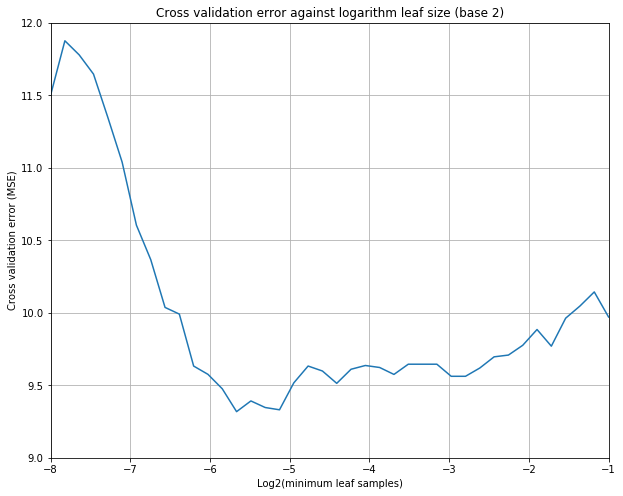

In [350]:
plt.figure(figsize=(10, 8))
plt.plot(
    gs_model_df['param_min_samples_leaf_log'],
    -gs_model_df['split0_test_neg_mean_squared_error']
)
plt.xlim(-8, -1)
plt.ylim(9, 12)
plt.title('Cross validation error against logarithm leaf size (base 2)')
plt.ylabel('Cross validation error (MSE)')
plt.xlabel('Log2(minimum leaf samples)')
plt.grid()
plt.show()

# Evaluating model

## Decision tree

In [173]:
model = DecisionTreeRegressor(min_samples_leaf=0.0193)
model.fit(X_train, y_train.ravel())

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=0.0193,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=None, splitter='best')

In [174]:
# get predictions for test set
y_pred = model.predict(X_test).flatten()

# calculate cross entropy loss for test set
test_loss = (
    mean_absolute_error(y_test, y_pred),
    mean_squared_error(y_test, y_pred),
    r2_score(y_test, y_pred)
)
test_loss

(2.202194201268388, 9.257678438677576, 0.110422087387268)

In [175]:
# refit model on all data
model_full = DecisionTreeRegressor(min_samples_leaf=0.0193)
model_full.fit(X, y.ravel())

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=0.0193,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=None, splitter='best')

In [176]:
# get predictions for whole set
y_pred_full = model_full.predict(X).flatten()

# calculate cross entropy loss for test set
test_loss_full = (
    mean_absolute_error(y, y_pred_full),
    mean_squared_error(y, y_pred_full),
    r2_score(y, y_pred_full)
)
test_loss_full

(2.0437438598690747, 7.942682294985791, 0.16991849565589778)

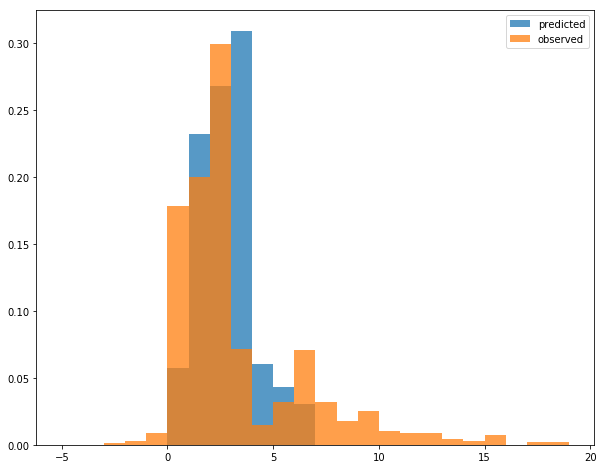

In [177]:
plt.figure(figsize=(10, 8))
plt.hist(pd.Series(y_pred), bins=range(-5,20), alpha=0.75, density=True, label='predicted')
plt.hist(pd.Series(y_test.ravel()), bins=range(-5,20), alpha=0.75, density=True, label='observed')
plt.legend()
plt.show()

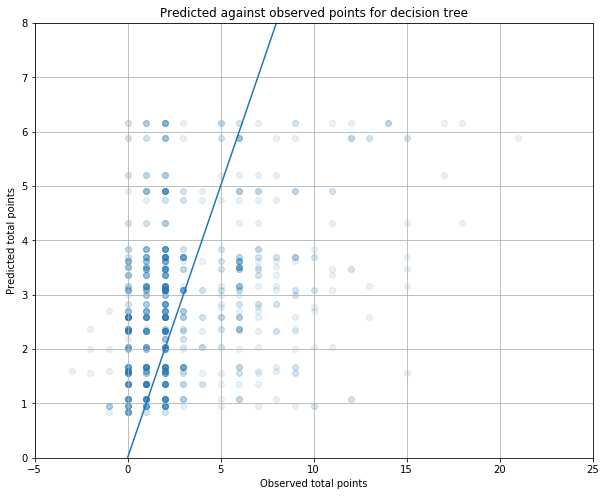

In [351]:
plt.figure(figsize=(10, 8))
plt.scatter(pd.Series(y_test.ravel()), pd.Series(y_pred), alpha=0.1)
plt.plot(np.linspace(-5, 25), np.linspace(-5, 25))
plt.ylabel('Predicted total points')
plt.xlabel('Observed total points')
plt.title('Predicted against observed points for decision tree')
plt.xlim((-5, 25))
plt.ylim((0, 8))
plt.grid()
plt.show()

### Model analysis

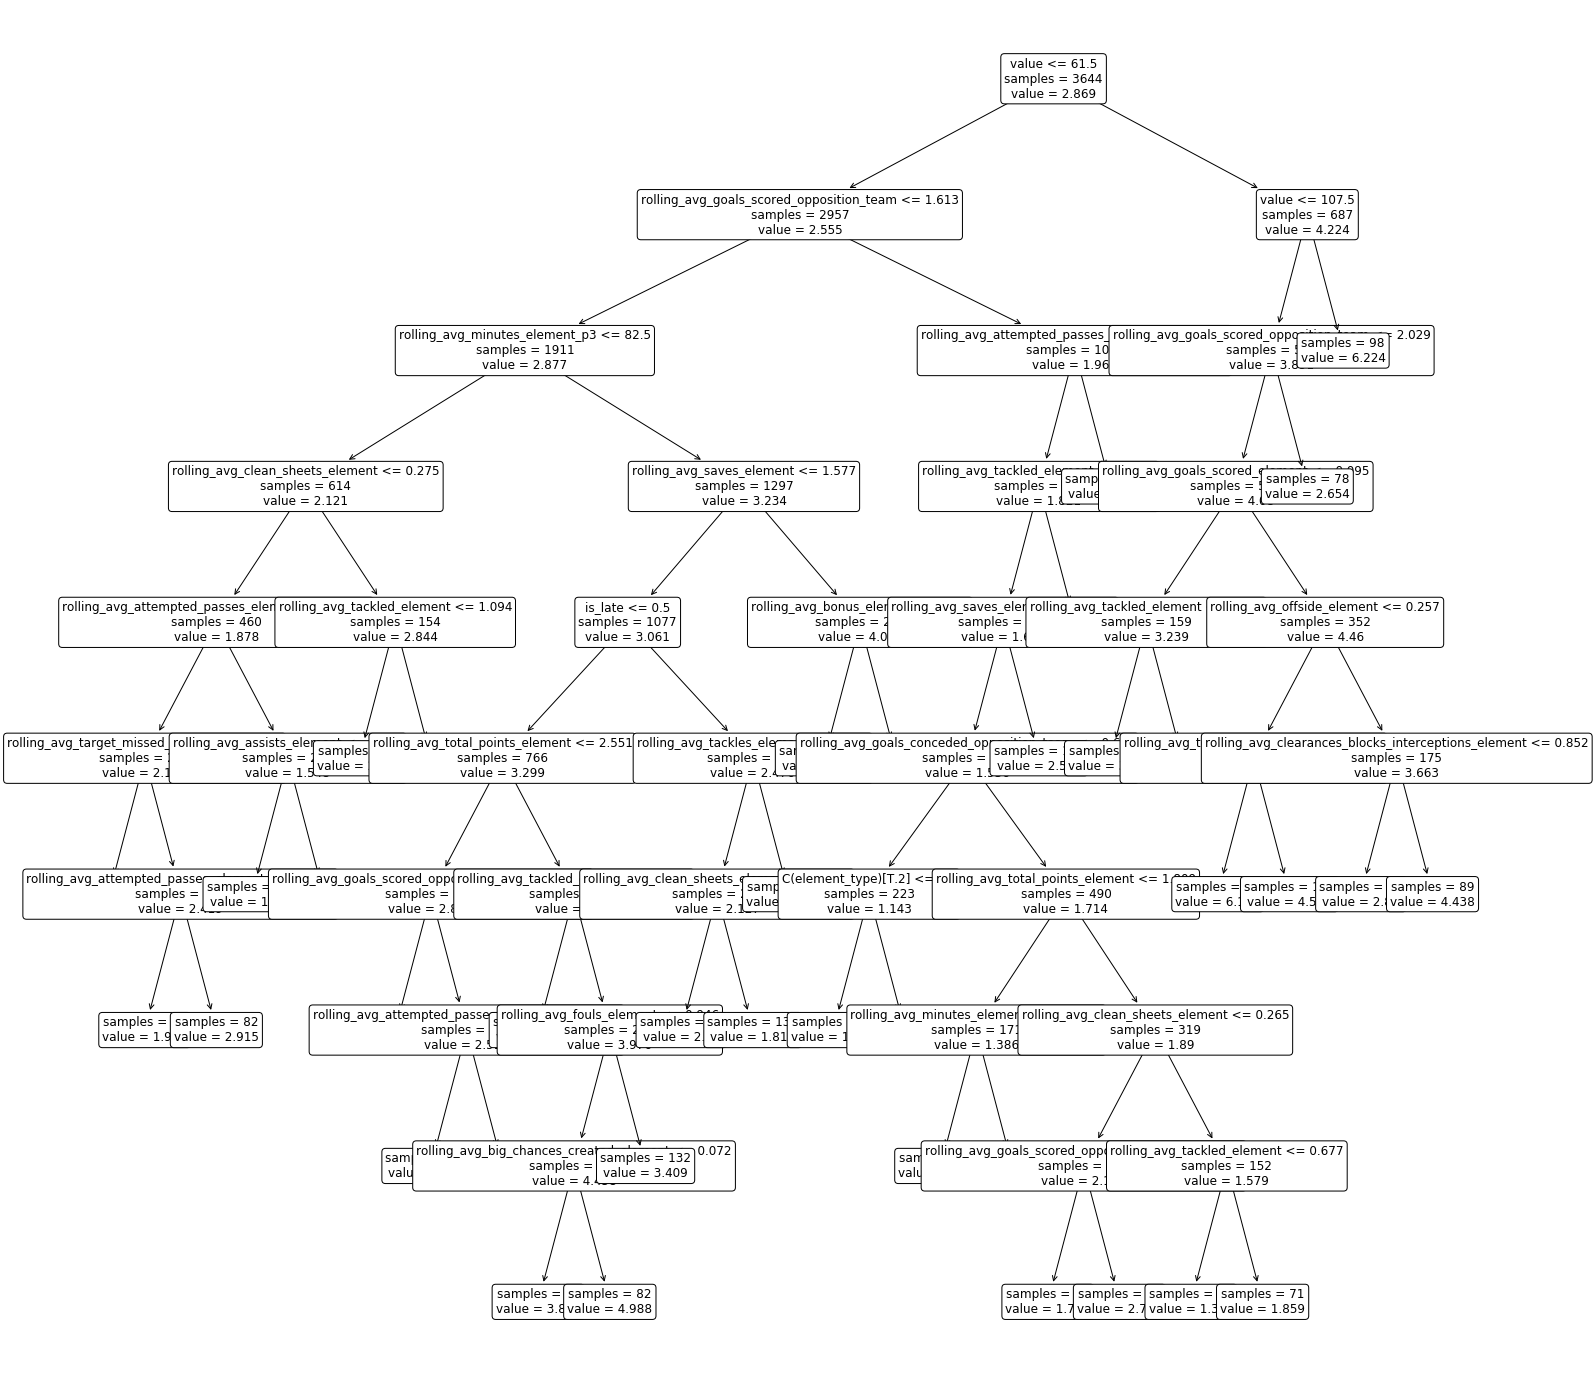

In [179]:
plt.figure(figsize=(25, 25))
plot_tree(
    model_full,
    impurity=False,
    fontsize=12,
    rounded=True,
    feature_names=X.design_info.column_names)
plt.show()

In [180]:
model_df = pd.DataFrame(list(zip(X.design_info.column_names, model_full.feature_importances_)),
                        columns=['feture', 'weight'])

In [181]:
model_df[model_df['weight'] != 0].sort_values('weight', ascending=False)

,feture,weight
47,value,0.339475
77,rolling_avg_goals_scored_opposition_team,0.143025
75,rolling_avg_minutes_element_p3,0.089622
56,rolling_avg_tackled_element,0.064896
66,rolling_avg_attempted_passes_element,0.055464
65,rolling_avg_saves_element,0.051785
48,rolling_avg_total_points_element,0.041541
63,rolling_avg_offside_element,0.037348
52,rolling_avg_clean_sheets_element,0.028842
51,rolling_avg_goals_scored_element,0.027571


In [293]:
model.get_depth()

10

## Summary

In [182]:
pd.DataFrame([
    ('Decision tree', test_loss[0], test_loss[1], test_loss[2]),
], columns=['model', 'MAE', 'MSE', 'r2'])

,model,MAE,MSE,r2
0,Decision tree,2.202194,9.257678,0.110422


In [183]:
pd.DataFrame([
    ('Decision tree', test_loss_full[0], test_loss_full[1], test_loss_full[2]),
], columns=['model', 'MAE', 'MSE', 'r2'])

,model,MAE,MSE,r2
0,Decision tree,2.043744,7.942682,0.169918


# Example tree

In [ ]:
# refit model on all data
model_full = DecisionTreeRegressor(min_samples_leaf=0.0193)
model_full.fit(X, y.ravel())

In [188]:
X.design_info.column_names

['Intercept',
 'C(element_type)[T.2]',
 'C(element_type)[T.3]',
 'C(element_type)[T.4]',
 'C(team)[T.2]',
 'C(team)[T.3]',
 'C(team)[T.4]',
 'C(team)[T.5]',
 'C(team)[T.6]',
 'C(team)[T.7]',
 'C(team)[T.8]',
 'C(team)[T.9]',
 'C(team)[T.10]',
 'C(team)[T.11]',
 'C(team)[T.12]',
 'C(team)[T.13]',
 'C(team)[T.14]',
 'C(team)[T.15]',
 'C(team)[T.16]',
 'C(team)[T.17]',
 'C(team)[T.18]',
 'C(team)[T.19]',
 'C(team)[T.20]',
 'C(opposition_team)[T.2]',
 'C(opposition_team)[T.3]',
 'C(opposition_team)[T.4]',
 'C(opposition_team)[T.5]',
 'C(opposition_team)[T.6]',
 'C(opposition_team)[T.7]',
 'C(opposition_team)[T.8]',
 'C(opposition_team)[T.9]',
 'C(opposition_team)[T.10]',
 'C(opposition_team)[T.11]',
 'C(opposition_team)[T.12]',
 'C(opposition_team)[T.13]',
 'C(opposition_team)[T.14]',
 'C(opposition_team)[T.15]',
 'C(opposition_team)[T.16]',
 'C(opposition_team)[T.17]',
 'C(opposition_team)[T.18]',
 'C(opposition_team)[T.19]',
 'C(opposition_team)[T.20]',
 'was_home',
 'is_sunday',
 'is_we

In [223]:
example_cols = [
    'is_late',
    'value',
]

example_features_index = \
[True if i in example_cols else False for i in X.design_info.column_names]

X_example = X[:,example_features_index]


In [224]:
model_example = DecisionTreeRegressor(max_depth=3)

model_example.fit(X_example, y.ravel())

DecisionTreeRegressor(criterion='mse', max_depth=3, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=None, splitter='best')

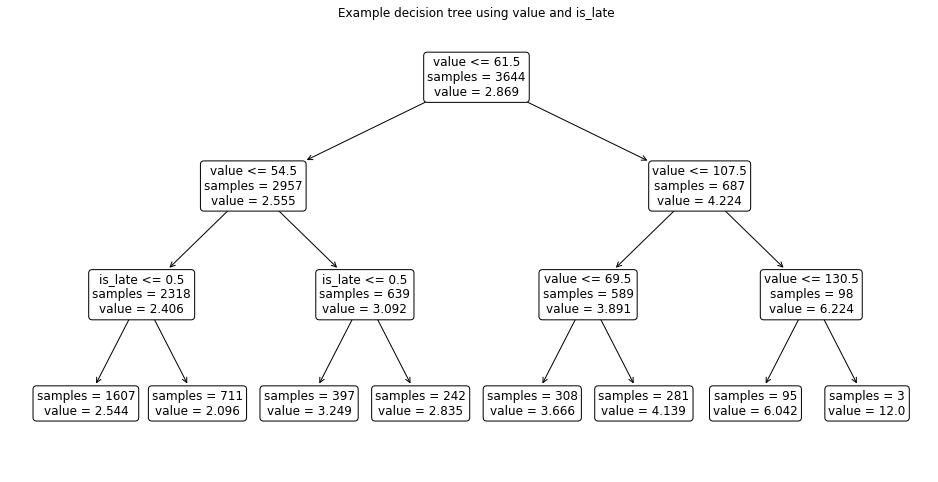

In [229]:
plt.figure(figsize=(16, 8))
plot_tree(
    model_example,
    impurity=False,
    fontsize=12,
    rounded=True,
    feature_names=example_cols
)
plt.title('Example decision tree using value and is_late')
plt.show()

In [241]:
data_boot = random.choices(list(zip(X_example, y.ravel())), k=len(X_example)) 
X_boot = [i[0] for i in data_boot]
y_boot = [i[1] for i in data_boot]

In [243]:
model_boot = DecisionTreeRegressor(max_depth=3)

model_boot.fit(X_boot, y_boot)

DecisionTreeRegressor(criterion='mse', max_depth=3, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=None, splitter='best')

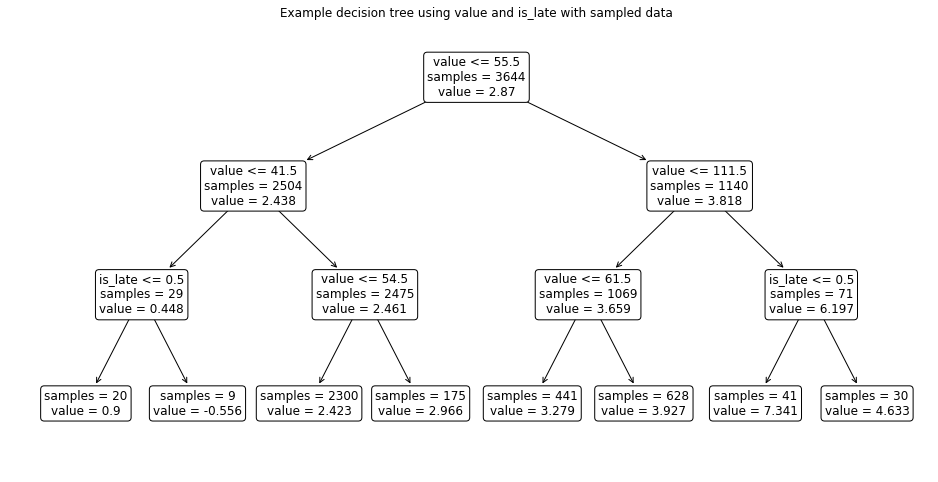

In [295]:
plt.figure(figsize=(16, 8))
plot_tree(
    model_boot,
    impurity=False,
    fontsize=12,
    rounded=True,
    feature_names=example_cols
)
plt.title('Example decision tree using value and is_late with sampled data')
plt.show()